In [ ]:
import numpy as np
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import pandas as pd
import os

# Loading the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Function to resize an image based on VGG16 input size
def resize_image(image, target_size=(224, 224)):
    img = image.resize(target_size)
    return img

# Function to extract features from an image using the VGG16 model
def extract_features(image_path):
    img = Image.open(image_path)  # Open the image using PIL
    img = img.convert('RGB')  # Convert the image to RGB (if it's grayscale)
    img = resize_image(img)  # Resize the image
    x = image.img_to_array(img)  # Convert image to array
    x = np.expand_dims(x, axis=0)  # Add an extra dimension to match VGG16 input shape
    x = preprocess_input(x)  # Preprocess the input (e.g., normalization)

    features = model.predict(x)  # Extract features using VGG16

    return features.flatten()  # Flatten the features to a 1D array


# Loading the movie data including IMDb ID, link, local image path, and other attributes
data = pd.read_csv("C:/Users/KIIT/Downloads/archive (1)/movies.csv")  # Replace with the actual path to your movie data CSV file

# Specify the path to the image folder
image_folder = "C:/Users/KIIT/Downloads/archive (1)/images/images" # Replace with the path to your image folder

duplicate_imdb_ids = data['imdbId'].duplicated()
print("Number of duplicate IMDb IDs:", duplicate_imdb_ids.sum())
data = data.drop_duplicates(subset='imdbId', keep='first')

# Extract visual features for each image and store in a list
visual_features = None  # Initialize as None
missing_images = []

for index, row in data.iterrows():
    imdb_id = str(row['imdbId'])  # Convert the IMDb ID to a string
    image_filename = imdb_id + '_.jpg'  # Append the underscore and the file extension to the IMDb ID
    image_path = os.path.join(image_folder, image_filename)  # Concatenate the image folder path with the modified image filename
    image_path = os.path.normpath(image_path)  # Normalize the path for OS compatibility
    
    print(f"Processing image: {image_filename}")

    if os.path.exists(image_path):
        features = extract_features(image_path)
        if visual_features is None:
            visual_features = features.reshape(1, -1)
        else:
            features = features.reshape(1, -1)
            visual_features = np.concatenate((visual_features, features), axis=0)
        print("Features extracted successfully.")
    else:
        missing_images.append(image_path)
        print("Image not found.")

    print("")

# Convert the list of missing images to a DataFrame
missing_images_df = pd.DataFrame(missing_images, columns=['image_path'])

# Merge the missing images DataFrame with the original data using IMDB ID as the key
combined_data = pd.merge(data, missing_images_df, left_on='imdbId', right_index=True, how='left')



image_folder_path = 'C:/Users/KIIT/Downloads/archive (1)/images/images/'  # Replace with the base folder path

# Update the image path column
combined_data['image_path'] = image_folder + combined_data['image_path']


# Print the combined data
print(combined_data)


Number of duplicate IMDb IDs: 97
Processing image: 114709_.jpg
1/1 [==============================] - 1s 566ms/step
Features extracted successfully.

Processing image: 113497_.jpg
1/1 [==============================] - 0s 160ms/step
Features extracted successfully.

Processing image: 113277_.jpg
1/1 [==============================] - 0s 150ms/step
Features extracted successfully.

Processing image: 114319_.jpg
1/1 [==============================] - 0s 136ms/step
Features extracted successfully.

Processing image: 114576_.jpg
1/1 [==============================] - 0s 203ms/step
Features extracted successfully.

Processing image: 113189_.jpg
1/1 [==============================] - 0s 163ms/step
Features extracted successfully.

Processing image: 112346_.jpg
1/1 [==============================] - 0s 148ms/step
Features extracted successfully.

Processing image: 112896_.jpg
1/1 [==============================] - 0s 138ms/step
Features extracted successfully.

Processing image: 113987_.jpg
1

In [3]:
print(combined_data.head())

   imdbId                           Imdb Link                Title  \
0  114709  http://www.imdb.com/title/tt114709     Toy Story (1995)   
1  113497  http://www.imdb.com/title/tt113497       Jumanji (1995)   
2  113277  http://www.imdb.com/title/tt113277          Heat (1995)   
3  114319  http://www.imdb.com/title/tt114319       Sabrina (1995)   
4  114576  http://www.imdb.com/title/tt114576  Sudden Death (1995)   

   IMDB Score                       Genre    local_image_path image_path  
0         8.3  Animation;Adventure;Comedy  images/114709_.jpg        NaN  
1         6.9     Action;Adventure;Family  images/113497_.jpg        NaN  
2         8.2          Action;Crime;Drama  images/113277_.jpg        NaN  
3         6.3                Comedy;Drama  images/114319_.jpg        NaN  
4         5.7       Action;Crime;Thriller  images/114576_.jpg        NaN  


## Review dataset. merging the movies datset with the review dataset.

In [4]:
# Load the review dataset
review_data_path = "C:/Users/KIIT/Downloads/archive (1)/reviews.csv"  # Replace with the actual path to the review dataset
review_df = pd.read_csv(review_data_path)

In [5]:
# Rename the column in the review dataset
review_df = review_df.rename(columns={'movie': 'Title'})

# Drop duplicate movie titles from review_df
review_df = review_df.drop_duplicates(subset='Title')

# Merge the movie and review datasets based on the common identifier (Title)
merged_df = pd.merge(combined_data, review_df, on='Title')
print(merged_df.shape)

(4071, 15)


# Textual Feature Extraction

In [6]:
# Textual feature extraction

# Combine the review summary and review detail into a single text feature
merged_df['review_text'] = merged_df['review_summary'] + ' ' + merged_df['review_detail']

# Sentiment analysis
from textblob import TextBlob
merged_df['review_sentiment'] = merged_df['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [7]:
print(merged_df.shape)

(4071, 17)


In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing subsets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Print the shapes of the subsets
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


Training set shape: (3256, 17)
Testing set shape: (815, 17)


In [9]:
# Filter the DataFrame to include only the movies with available visual features
filtered_df = merged_df[:len(visual_features)].copy()

# Extract the visual features for movies present in the DataFrame
visual_features_reshaped = visual_features.reshape(len(visual_features), -1)

# Concatenate the textual and visual features
concatenated_features = np.hstack((filtered_df[['review_sentiment']].values, visual_features_reshaped))

# Update the filtered DataFrame with the concatenated features
filtered_df.loc[:, 'concatenated_features'] = list(concatenated_features)

# Print the shape of the filtered DataFrame
print("Filtered DataFrame shape:", filtered_df.shape)


Filtered DataFrame shape: (4071, 18)


In [10]:
print(filtered_df.head())
print(filtered_df.tail())

   imdbId                           Imdb Link                Title  \
0  114709  http://www.imdb.com/title/tt114709     Toy Story (1995)   
1  113497  http://www.imdb.com/title/tt113497       Jumanji (1995)   
2  113277  http://www.imdb.com/title/tt113277          Heat (1995)   
3  114319  http://www.imdb.com/title/tt114319       Sabrina (1995)   
4  114576  http://www.imdb.com/title/tt114576  Sudden Death (1995)   

   IMDB Score                       Genre    local_image_path image_path  \
0         8.3  Animation;Adventure;Comedy  images/114709_.jpg        NaN   
1         6.9     Action;Adventure;Family  images/113497_.jpg        NaN   
2         8.2          Action;Crime;Drama  images/113277_.jpg        NaN   
3         6.3                Comedy;Drama  images/114319_.jpg        NaN   
4         5.7       Action;Crime;Thriller  images/114576_.jpg        NaN   

   review_id             reviewer  rating  \
0  rw1166979             dee.reid    10.0   
1  rw1170725               golem

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendation(movie_id, top_k=20):
    # Get the index of the movie in the DataFrame
    movie_index = filtered_df[filtered_df['imdbId'] == movie_id].index[0]

    # Get the similarity scores for the movie
    similarity_scores = cosine_similarity(filtered_df['concatenated_features'].tolist())
    movie_scores = similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs of the top-k recommended movies
    top_k_recommendations = filtered_df.loc[top_indices, 'imdbId'].tolist()

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = content_based_recommendation(movie_id, top_k=5)

print("Top 5 recommended movies:")
for imdb_id in top_k_recommendations:
    movie_title = filtered_df.loc[filtered_df['imdbId'] == imdb_id, 'Title'].values[0]
    print(imdb_id, "-", movie_title)


Top 5 recommended movies:
114709 - Toy Story (1995)
101414 - Beauty and the Beast (1991)
445922 - Across the Universe (2007)
97659 - Kickboxer (1989)
993842 - Hanna (2011)


## Using Cosine similarity to calculate the similarity score

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

def content_based_recommendation(movie_id, top_k=5):
    # Get the index of the movie in the DataFrame
    movie_index = filtered_df[filtered_df['imdbId'] == movie_id].index[0]

    # Get the textual and visual features for all movies
    features = filtered_df['concatenated_features'].tolist()

    # Compute the cosine similarity between the features
    similarity_scores = cosine_similarity(features)

    # Get the similarity scores for the movie
    movie_scores = similarity_scores[movie_index]

    # Scale the cosine similarity scores between 1 and 5 to match the rating scale
    scaler = MinMaxScaler(feature_range=(1, 5))
    scaled_scores = scaler.fit_transform(movie_scores.reshape(-1, 1)).flatten()

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-scaled_scores)[:top_k]

    # Get the IMDb IDs of the top-k recommended movies
    top_k_recommendations = filtered_df.loc[top_indices, 'imdbId'].tolist()

    return top_k_recommendations

# Example usage:
movie_title = "Mortal Kombat (1995)"  # Specify the movie title for which you want recommendations
movie_id = filtered_df.loc[filtered_df['Title'] == movie_title, 'imdbId'].values[0]
top_k_recommendations = content_based_recommendation(movie_id, top_k=5)

print("Top 5 recommended movies for", movie_title + ":")
for imdb_id in top_k_recommendations:
    movie_title = filtered_df.loc[filtered_df['imdbId'] == imdb_id, 'Title'].values[0]
    print(imdb_id, "-", movie_title)


Top 5 recommended movies for Mortal Kombat (1995):
113855 - Mortal Kombat (1995)
66473 - Tora! Tora! Tora! (1970)
1020072 - Selma (2014)
120201 - Starship Troopers (1997)
2180411 - Into the Woods (2014)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix
similarity_matrix = cosine_similarity(concatenated_features)

# Print the shape of the similarity matrix
print("Similarity Matrix shape:", similarity_matrix.shape)


Similarity Matrix shape: (4071, 4071)


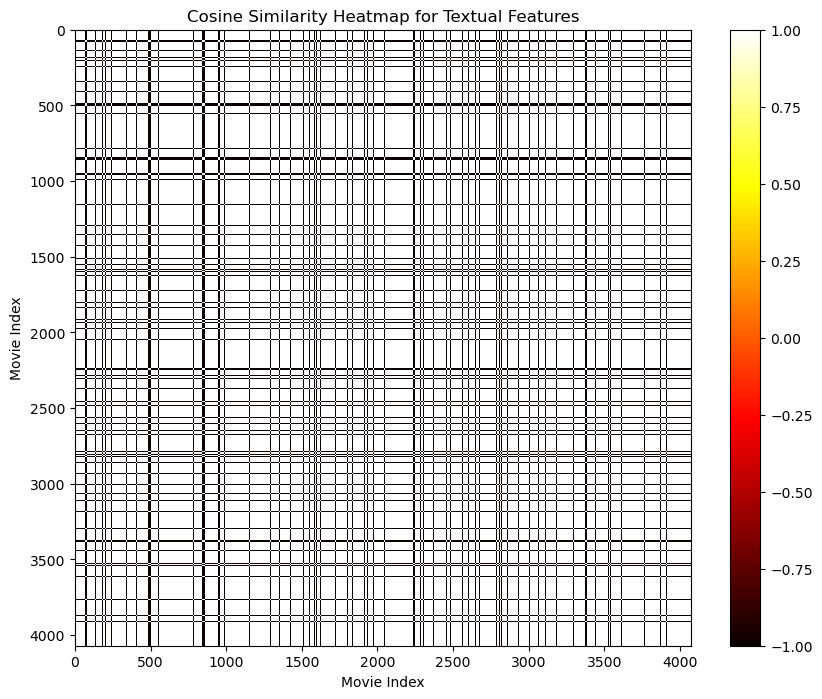

In [15]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Get the textual features from the merged_df DataFrame
textual_features = merged_df['review_sentiment'].values.reshape(-1, 1)

# Compute the cosine similarity between the textual features
textual_similarity_scores = cosine_similarity(textual_features)

# Generate the heatmap for textual features
plt.figure(figsize=(10, 8))
plt.imshow(textual_similarity_scores, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Heatmap for Textual Features")
plt.xlabel("Movie Index")
plt.ylabel("Movie Index")
plt.show()

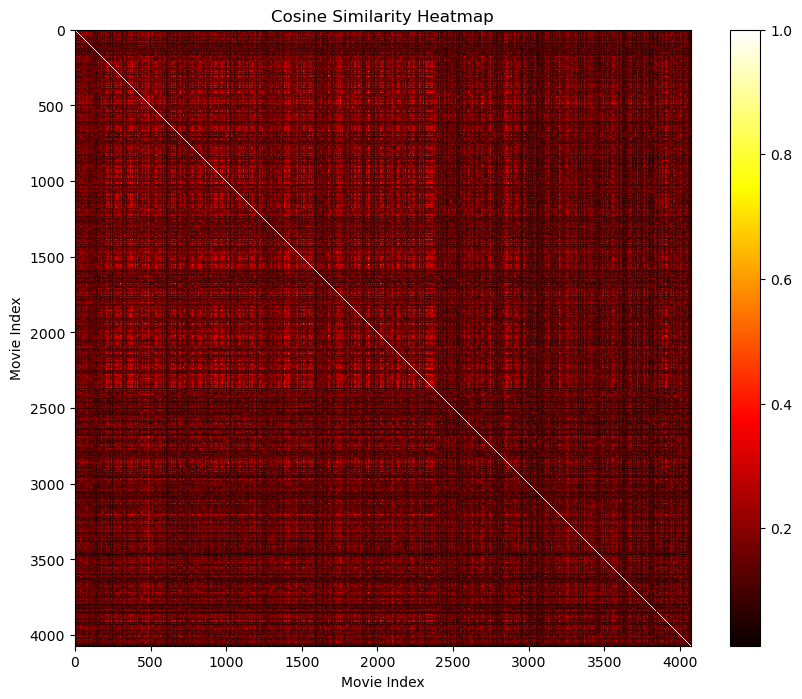

In [13]:
import matplotlib.pyplot as plt

# Compute the cosine similarity between the concatenated features
similarity_scores = cosine_similarity(concatenated_features)

# Generate the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(similarity_scores, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Heatmap")
plt.xlabel("Movie Index")
plt.ylabel("Movie Index")
plt.show()


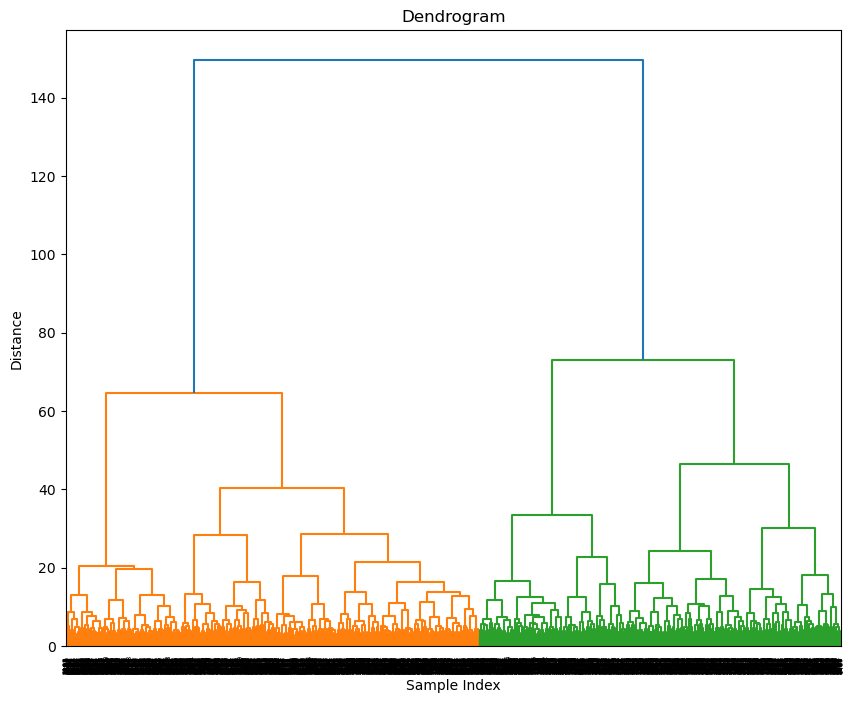

In [17]:
from scipy.cluster.hierarchy import ward, dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the dendrogram
linkage_matrix = linkage(similarity_matrix, method='ward')

plt.figure(figsize=(10, 8))
dendrogram(linkage_matrix)
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


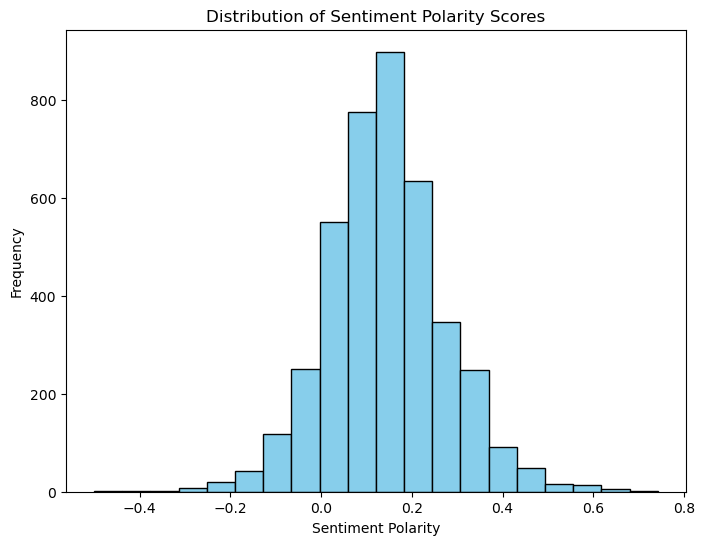

In [19]:
import matplotlib.pyplot as plt

# Plot the sentiment polarity scores
plt.figure(figsize=(8, 6))
plt.hist(merged_df['review_sentiment'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity Scores')
plt.show()


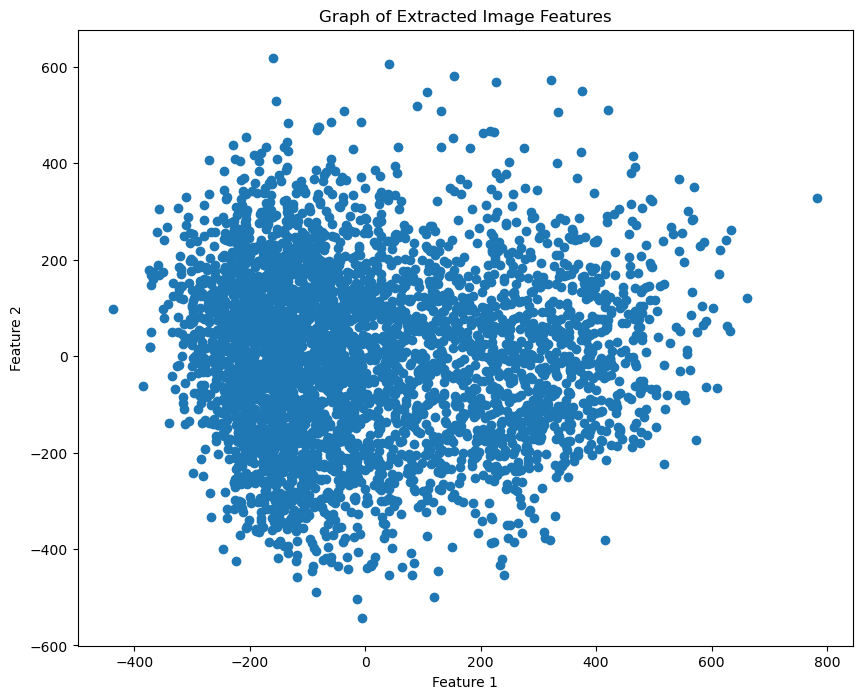

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the dimensionality of the visual features to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(visual_features)

# Plot the reduced features
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.title("Graph of Extracted Image Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


# Increasing the recommendation to 10 movies

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendation(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = filtered_df[filtered_df['imdbId'] == movie_id].index[0]

    # Get the similarity scores for the movie
    concatenated_similarity_scores = cosine_similarity(filtered_df['concatenated_features'].tolist())
    movie_scores = concatenated_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs of the top-k recommended movies
    top_k_recommendations = filtered_df.loc[top_indices, 'imdbId'].tolist()

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = content_based_recommendation(movie_id, top_k=10)


print("Top 10 recommended movies:")
for imdb_id in top_k_recommendations:
    movie_title = filtered_df.loc[filtered_df['imdbId'] == imdb_id, 'Title'].values[0]
    print(imdb_id, "-", movie_title)    

Top 10 recommended movies:
114709 - Toy Story (1995)
101414 - Beauty and the Beast (1991)
445922 - Across the Universe (2007)
97659 - Kickboxer (1989)
993842 - Hanna (2011)
1618442 - The Last Witch Hunter (2015)
319343 - Elf (2003)
938283 - The Last Airbender (2010)
33563 - Dumbo (1941)
2245084 - Big Hero 6 (2014)


In [31]:
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendation(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = filtered_df[filtered_df['imdbId'] == movie_id].index[0]

    # Get the similarity scores for the movie
    concatenated_similarity_scores = cosine_similarity(filtered_df['concatenated_features'].tolist())
    movie_scores = concatenated_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs and similarity scores of the top-k recommended movies
    top_k_recommendations = filtered_df.loc[top_indices, ['imdbId', 'Title']]
    top_k_recommendations['Similarity Score'] = movie_scores[top_indices]

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = content_based_recommendation(movie_id, top_k=10)

print("Top 10 recommended movies:")
for index, row in top_k_recommendations.iterrows():
    imdb_id = row['imdbId']
    movie_title = row['Title']
    similarity_score = row['Similarity Score']
    print(imdb_id, "-", movie_title, "(Similarity Score:", similarity_score, ")")


Top 10 recommended movies:
114709 - Toy Story (1995) (Similarity Score: 1.0000000000000009 )
101414 - Beauty and the Beast (1991) (Similarity Score: 0.2573413611294484 )
445922 - Across the Universe (2007) (Similarity Score: 0.24277241434076374 )
97659 - Kickboxer (1989) (Similarity Score: 0.23196872910331726 )
993842 - Hanna (2011) (Similarity Score: 0.23078689810873634 )
1618442 - The Last Witch Hunter (2015) (Similarity Score: 0.22804216068576433 )
319343 - Elf (2003) (Similarity Score: 0.2259571158571406 )
938283 - The Last Airbender (2010) (Similarity Score: 0.22539312879853757 )
33563 - Dumbo (1941) (Similarity Score: 0.22372711877025883 )
2245084 - Big Hero 6 (2014) (Similarity Score: 0.2237130877763648 )


Top 10 recommended movies:
114709 - Toy Story (1995) (Similarity Score: 1.0000000000000009 )
101414 - Beauty and the Beast (1991) (Similarity Score: 0.2573413611294484 )
445922 - Across the Universe (2007) (Similarity Score: 0.24277241434076374 )
97659 - Kickboxer (1989) (Similarity Score: 0.23196872910331726 )
993842 - Hanna (2011) (Similarity Score: 0.23078689810873634 )
1618442 - The Last Witch Hunter (2015) (Similarity Score: 0.22804216068576433 )
319343 - Elf (2003) (Similarity Score: 0.2259571158571406 )
938283 - The Last Airbender (2010) (Similarity Score: 0.22539312879853757 )
33563 - Dumbo (1941) (Similarity Score: 0.22372711877025883 )
2245084 - Big Hero 6 (2014) (Similarity Score: 0.2237130877763648 )


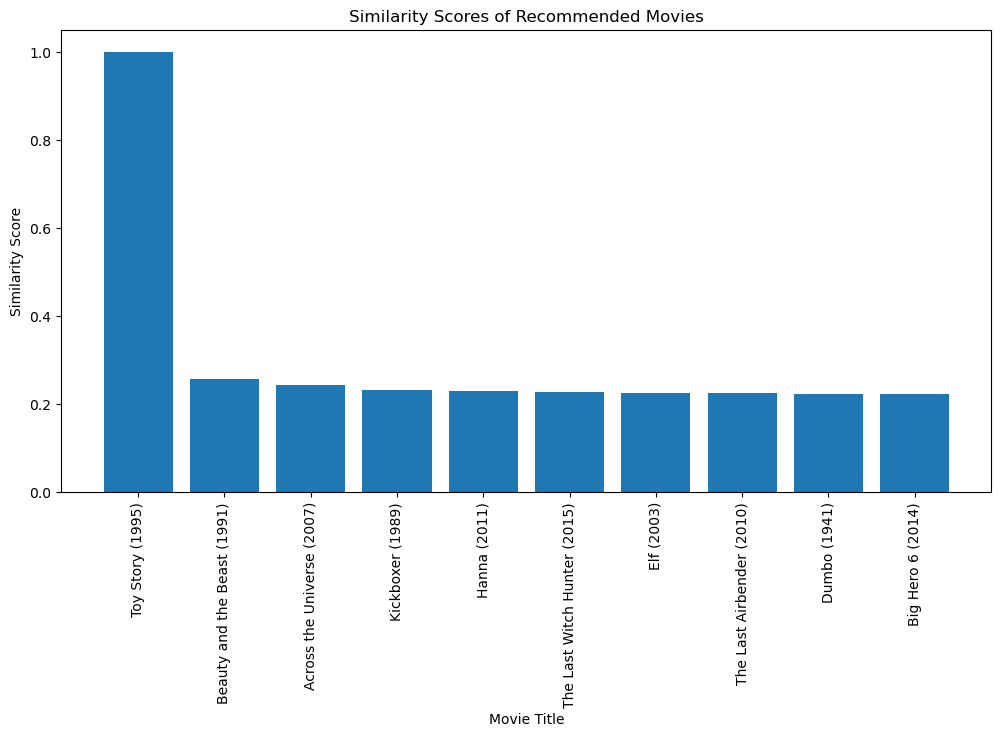

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendation(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = filtered_df[filtered_df['imdbId'] == movie_id].index[0]

    # Get the similarity scores for the movie
    concatenated_similarity_scores = cosine_similarity(filtered_df['concatenated_features'].tolist())
    movie_scores = concatenated_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs and similarity scores of the top-k recommended movies
    top_k_recommendations = filtered_df.loc[top_indices, ['imdbId', 'Title']]
    top_k_recommendations['Similarity Score'] = movie_scores[top_indices]

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = content_based_recommendation(movie_id, top_k=10)

print("Top 10 recommended movies:")
for index, row in top_k_recommendations.iterrows():
    imdb_id = row['imdbId']
    movie_title = row['Title']
    similarity_score = row['Similarity Score']
    print(imdb_id, "-", movie_title, "(Similarity Score:", similarity_score, ")")

# Plot the similarity scores
plt.figure(figsize=(12, 6))
plt.bar(top_k_recommendations['Title'], top_k_recommendations['Similarity Score'])
plt.xlabel('Movie Title')
plt.ylabel('Similarity Score')
plt.xticks(rotation=90)
plt.title('Similarity Scores of Recommended Movies')
plt.show()


## Recommendation based on Visual features only

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies_visual(movie_id, top_k=5):
    # Get the index of the movie in the DataFrame
    movie_index = combined_data[combined_data['imdbId'] == movie_id].index[0]

    # Compute the cosine similarity between visual features
    visual_similarity_scores = cosine_similarity(visual_features)

    # Get the similarity scores for the movie
    movie_scores = visual_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs of the top-k recommended movies
    top_k_recommendations = combined_data.loc[top_indices, 'imdbId'].tolist()

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_visual(movie_id, top_k=10)

print("Top 10 recommended movies based on visual features:")
for imdb_id in top_k_recommendations:
    movie_title = combined_data.loc[combined_data['imdbId'] == imdb_id, 'Title'].values[0]
    print(imdb_id, "-", movie_title)


Top 10 recommended movies based on visual features:
114709 - Toy Story (1995)
32910 - Pinocchio (1940)
462538 - The Simpsons Movie (2007)
97815 - Major League (1989)
485947 - Mr. Nobody (2009)
1216491 - Kill the Messenger (2014)
318155 - Looney Tunes: Back in Action (2003)
1477715 - This Is It (2009)
43274 - Alice in Wonderland (1951)
1742334 - Sabotage (2014)


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies_visual(movie_id, top_k=5):
    # Get the index of the movie in the DataFrame
    movie_index = combined_data[combined_data['imdbId'] == movie_id].index[0]

    # Compute the cosine similarity between visual features
    visual_similarity_scores = cosine_similarity(visual_features)

    # Get the similarity scores for the movie
    movie_scores = visual_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs and similarity scores of the top-k recommended movies
    top_k_recommendations = combined_data.loc[top_indices, ['imdbId', 'Title']]
    top_k_recommendations['Similarity Score'] = movie_scores[top_indices]

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_visual(movie_id, top_k=10)

print("Top 10 recommended movies based on visual features:")
for index, row in top_k_recommendations.iterrows():
    imdb_id = row['imdbId']
    movie_title = row['Title']
    similarity_score = row['Similarity Score']
    print(imdb_id, "-", movie_title, "(Similarity Score:", similarity_score, ")")


Top 10 recommended movies based on visual features:
114709 - Toy Story (1995) (Similarity Score: 1.0 )
32910 - Pinocchio (1940) (Similarity Score: 0.25734132528305054 )
462538 - The Simpsons Movie (2007) (Similarity Score: 0.2427724301815033 )
97815 - Major League (1989) (Similarity Score: 0.2319687455892563 )
485947 - Mr. Nobody (2009) (Similarity Score: 0.23078690469264984 )
1216491 - Kill the Messenger (2014) (Similarity Score: 0.22804218530654907 )
318155 - Looney Tunes: Back in Action (2003) (Similarity Score: 0.22595708072185516 )
1477715 - This Is It (2009) (Similarity Score: 0.2253931164741516 )
43274 - Alice in Wonderland (1951) (Similarity Score: 0.22372718155384064 )
1742334 - Sabotage (2014) (Similarity Score: 0.2237129956483841 )


Top 10 recommended movies based on visual features:
114709 - Toy Story (1995) (Similarity Score: 1.0 )
32910 - Pinocchio (1940) (Similarity Score: 0.25734132528305054 )
462538 - The Simpsons Movie (2007) (Similarity Score: 0.2427724301815033 )
97815 - Major League (1989) (Similarity Score: 0.2319687455892563 )
485947 - Mr. Nobody (2009) (Similarity Score: 0.23078690469264984 )
1216491 - Kill the Messenger (2014) (Similarity Score: 0.22804218530654907 )
318155 - Looney Tunes: Back in Action (2003) (Similarity Score: 0.22595708072185516 )
1477715 - This Is It (2009) (Similarity Score: 0.2253931164741516 )
43274 - Alice in Wonderland (1951) (Similarity Score: 0.22372718155384064 )
1742334 - Sabotage (2014) (Similarity Score: 0.2237129956483841 )


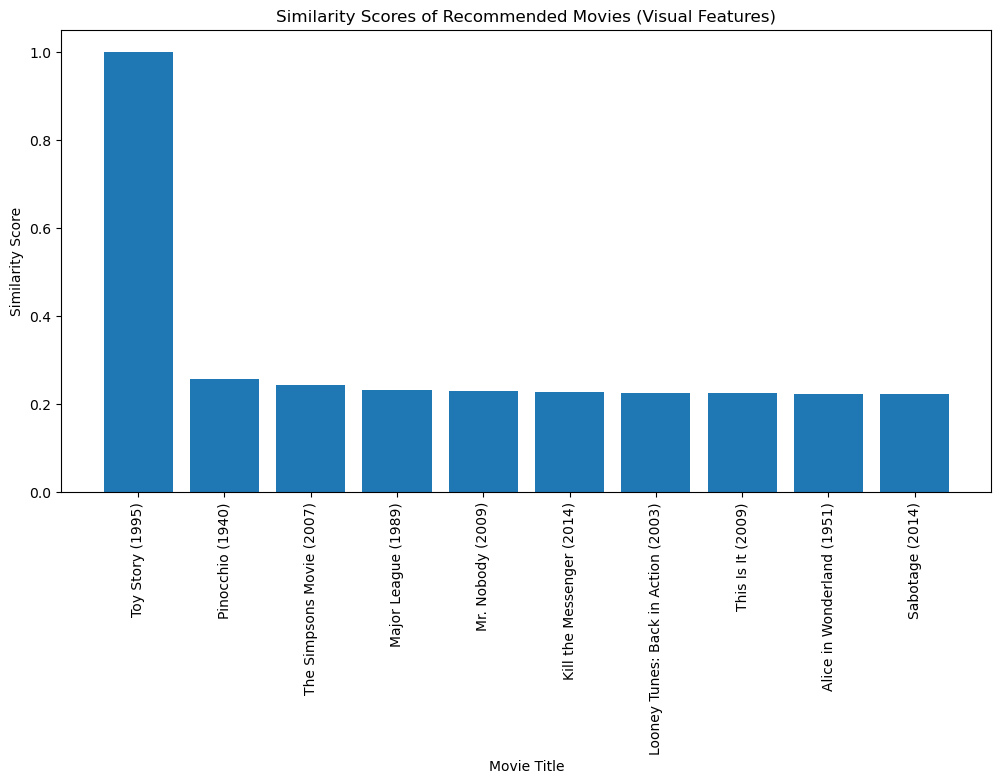

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies_visual(movie_id, top_k=5):
    # Get the index of the movie in the DataFrame
    movie_index = combined_data[combined_data['imdbId'] == movie_id].index[0]

    # Compute the cosine similarity between visual features
    visual_similarity_scores = cosine_similarity(visual_features)

    # Get the similarity scores for the movie
    movie_scores = visual_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs and similarity scores of the top-k recommended movies
    top_k_recommendations = combined_data.loc[top_indices, ['imdbId', 'Title']]
    top_k_recommendations['Similarity Score'] = movie_scores[top_indices]

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_visual(movie_id, top_k=10)

print("Top 10 recommended movies based on visual features:")
for index, row in top_k_recommendations.iterrows():
    imdb_id = row['imdbId']
    movie_title = row['Title']
    similarity_score = row['Similarity Score']
    print(imdb_id, "-", movie_title, "(Similarity Score:", similarity_score, ")")

# Plot the similarity scores
plt.figure(figsize=(12, 6))
plt.bar(top_k_recommendations['Title'], top_k_recommendations['Similarity Score'])
plt.xlabel('Movie Title')
plt.ylabel('Similarity Score')
plt.xticks(rotation=90)
plt.title('Similarity Scores of Recommended Movies (Visual Features)')
plt.show()


In [22]:
print(review_df.head())

   review_id             reviewer                     Title  rating  \
0  rw1133942  OriginalMovieBuff21  Kill Bill: Vol. 2 (2004)     8.0   
1  rw1133959        lost-in-limbo         Feardotcom (2002)     3.0   
2  rw1133985             NateManD            Persona (1966)    10.0   
3  rw1133999            CAMACHO-4  War of the Worlds (2005)     3.0   
4  rw1134010            CAMACHO-4   Mr. & Mrs. Smith (2005)     6.0   

                                      review_summary   review_date  \
0      Good follow up that answers all the questions  24 July 2005   
1  "I couldn't make much sense of it myself". Too...  24 July 2005   
2  Persona gives me all the reasons to love art-h...  24 July 2005   
3  A disappointing film from the team that you Mi...  24 July 2005   
4            A fun action movie with great chemistry  24 July 2005   

   spoiler_tag                                      review_detail      helpful  
0            0  After seeing Tarantino's Kill Bill Vol: 1, I g...   ['0

In [23]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

# Merge the movie and review datasets based on the common identifier (Title)
merged_df = pd.merge(data, review_df, on='Title')

# Combine the review summary and review detail into a single text feature
merged_df['review_text'] = merged_df['review_summary'] + ' ' + merged_df['review_detail']

# Sentiment analysis
merged_df['review_sentiment'] = merged_df['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Filter the merged dataframe to include only the movies present in the movies dataset
filtered_merged_df = merged_df[merged_df['imdbId'].isin(data['imdbId'])]

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Convert review text to features
textual_features = vectorizer.fit_transform(filtered_merged_df['review_text'])
textual_features = textual_features.toarray()

# Print the shape of the textual features
print("Textual Features shape:", textual_features.shape)


Textual Features shape: (4071, 41347)


## Recommendation based on Textual features(text + sentiment)

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies_textual(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = merged_df[merged_df['imdbId'] == movie_id].index[0]

    # Compute the cosine similarity between textual features
    textual_features_similarity_scores = cosine_similarity(textual_features)

    # Get the similarity scores for the movie
    movie_scores = textual_features_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs of the top-k recommended movies
    top_k_recommendations = merged_df.loc[top_indices, 'imdbId'].tolist()

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_textual(movie_id, top_k=10)


print("Top 10 recommended movies based on textual features:")
for imdb_id in top_k_recommendations:
    movie_title = merged_df.loc[merged_df['imdbId'] == imdb_id, 'Title'].values[0]
    print(imdb_id, "-", movie_title)


Top 10 recommended movies based on textual features:
114709 - Toy Story (1995)
1156398 - Zombieland (2009)
1398426 - Straight Outta Compton (2015)
68699 - High Plains Drifter (1973)
862467 - Valhalla Rising (2009)
1791528 - Inherent Vice (2014)
363589 - Elephant (2003)
4262980 - Shin Godzilla (2016)
914863 - Unthinkable (2010)
1226681 - Pontypool (2008)


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies_textual(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = merged_df[merged_df['imdbId'] == movie_id].index[0]

    # Compute the cosine similarity between textual features
    textual_features_similarity_scores = cosine_similarity(textual_features)

    # Get the similarity scores for the movie
    movie_scores = textual_features_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs and similarity scores of the top-k recommended movies
    top_k_recommendations = merged_df.loc[top_indices, ['imdbId', 'Title']]
    top_k_recommendations['Similarity Score'] = movie_scores[top_indices]

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_textual(movie_id, top_k=10)

print("Top 10 recommended movies based on textual features:")
for index, row in top_k_recommendations.iterrows():
    imdb_id = row['imdbId']
    movie_title = row['Title']
    similarity_score = row['Similarity Score']
    print(imdb_id, "-", movie_title, "(Similarity Score:", similarity_score, ")")


Top 10 recommended movies based on textual features:
114709 - Toy Story (1995) (Similarity Score: 0.9999999999999986 )
1156398 - Zombieland (2009) (Similarity Score: 0.7690097580209612 )
1398426 - Straight Outta Compton (2015) (Similarity Score: 0.7673081982439951 )
68699 - High Plains Drifter (1973) (Similarity Score: 0.764708286950256 )
862467 - Valhalla Rising (2009) (Similarity Score: 0.7589431510632229 )
1791528 - Inherent Vice (2014) (Similarity Score: 0.7587762508839507 )
363589 - Elephant (2003) (Similarity Score: 0.757658353655975 )
4262980 - Shin Godzilla (2016) (Similarity Score: 0.754325619391803 )
914863 - Unthinkable (2010) (Similarity Score: 0.7520666121714862 )
1226681 - Pontypool (2008) (Similarity Score: 0.7519176170244805 )


Top 10 recommended movies based on textual features:
114709 - Toy Story (1995) (Similarity Score: 0.9999999999999986 )
1156398 - Zombieland (2009) (Similarity Score: 0.7690097580209612 )
1398426 - Straight Outta Compton (2015) (Similarity Score: 0.7673081982439951 )
68699 - High Plains Drifter (1973) (Similarity Score: 0.764708286950256 )
862467 - Valhalla Rising (2009) (Similarity Score: 0.7589431510632229 )
1791528 - Inherent Vice (2014) (Similarity Score: 0.7587762508839507 )
363589 - Elephant (2003) (Similarity Score: 0.757658353655975 )
4262980 - Shin Godzilla (2016) (Similarity Score: 0.754325619391803 )
914863 - Unthinkable (2010) (Similarity Score: 0.7520666121714862 )
1226681 - Pontypool (2008) (Similarity Score: 0.7519176170244805 )


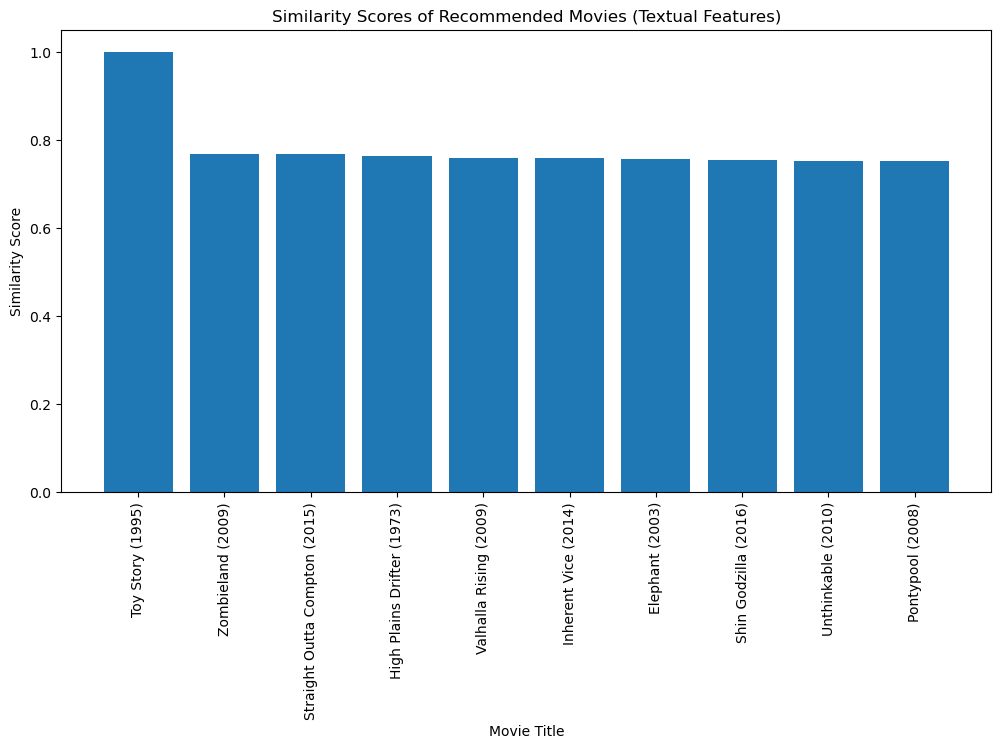

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies_textual(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = merged_df[merged_df['imdbId'] == movie_id].index[0]

    # Compute the cosine similarity between textual features
    textual_features_similarity_scores = cosine_similarity(textual_features)

    # Get the similarity scores for the movie
    movie_scores = textual_features_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs and similarity scores of the top-k recommended movies
    top_k_recommendations = merged_df.loc[top_indices, ['imdbId', 'Title']]
    top_k_recommendations['Similarity Score'] = movie_scores[top_indices]

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_textual(movie_id, top_k=10)

print("Top 10 recommended movies based on textual features:")
for index, row in top_k_recommendations.iterrows():
    imdb_id = row['imdbId']
    movie_title = row['Title']
    similarity_score = row['Similarity Score']
    print(imdb_id, "-", movie_title, "(Similarity Score:", similarity_score, ")")

# Plot the similarity scores
plt.figure(figsize=(12, 6))
plt.bar(top_k_recommendations['Title'], top_k_recommendations['Similarity Score'])
plt.xlabel('Movie Title')
plt.ylabel('Similarity Score')
plt.xticks(rotation=90)
plt.title('Similarity Scores of Recommended Movies (Textual Features)')
plt.show()


## Recommendation based on textual features.

In [44]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine the review summary and review detail into a single text feature
merged_df['review_text'] = merged_df['review_summary'] + ' ' + merged_df['review_detail']

# Clean the text data, perform tokenization, remove stop words, apply text normalization techniques, etc.

# Vectorize the text data
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(merged_df['review_text'])

# Compute the similarity scores
text_similarity_scores = cosine_similarity(text_features)

# Generate recommendations based on text similarity
def recommend_movies_text_only(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = merged_df[merged_df['imdbId'] == movie_id].index[0]

    # Get the similarity scores for the movie
    movie_scores = text_similarity_scores[movie_index]

    # Get the indices of the top-k similar movies
    top_indices = np.argsort(-movie_scores)[:top_k]

    # Get the IMDb IDs of the top-k recommended movies
    top_k_recommendations = merged_df.loc[top_indices, 'imdbId'].tolist()

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_text_only(movie_id, top_k=10)

print("Top 10 recommended movies based on text similarity:")
for imdb_id in top_k_recommendations:
    movie_title = merged_df.loc[merged_df['imdbId'] == imdb_id, 'Title'].values[0]
    print(imdb_id, "-", movie_title)


Top 10 recommended movies based on text similarity:
114709 - Toy Story (1995)
120363 - Toy Story 2 (1999)
1291150 - Teenage Mutant Ninja Turtles (2014)
317219 - Cars (2006)
1204342 - The Muppets (2011)
80437 - The Big Red One (1980)
1046173 - G.I. Joe: The Rise of Cobra (2009)
103060 - Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991)
3416532 - A Monster Calls (2016)
844708 - The Last House on the Left (2009)


In [28]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine the review summary and review detail into a single text feature
merged_df['review_text'] = merged_df['review_summary'] + ' ' + merged_df['review_detail']

# Clean the text data, perform tokenization, remove stop words, apply text normalization techniques, etc.

# Vectorize the text data
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(merged_df['review_text'])

# Compute the similarity scores
text_similarity_scores = cosine_similarity(text_features)

# Generate recommendations based on text similarity
def recommend_movies_text_only(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = merged_df[merged_df['imdbId'] == movie_id].index[0]

    # Get the similarity scores for the movie
    movie_scores = text_similarity_scores[movie_index]

    # Create a DataFrame with movie IDs and similarity scores
    similarity_df = pd.DataFrame({'imdbId': merged_df['imdbId'], 'similarity_score': movie_scores})

    # Sort the DataFrame based on similarity scores in descending order
    similarity_df = similarity_df.sort_values(by='similarity_score', ascending=False)

    # Get the IMDb IDs and similarity scores of the top-k recommended movies
    top_k_recommendations = similarity_df.head(top_k)

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_text_only(movie_id, top_k=10)

print("Top 10 recommended movies based on text similarity:")
for _, row in top_k_recommendations.iterrows():
    imdb_id = row['imdbId']
    movie_title = merged_df.loc[merged_df['imdbId'] == imdb_id, 'Title'].values[0]
    similarity_score = row['similarity_score']
    print(imdb_id, "-", movie_title, "(Similarity Score:", similarity_score, ")")


Top 10 recommended movies based on text similarity:
114709.0 - Toy Story (1995) (Similarity Score: 0.9999999999999999 )
120363.0 - Toy Story 2 (1999) (Similarity Score: 0.4605663921644475 )
1291150.0 - Teenage Mutant Ninja Turtles (2014) (Similarity Score: 0.25789960816496593 )
317219.0 - Cars (2006) (Similarity Score: 0.25480931744022484 )
1204342.0 - The Muppets (2011) (Similarity Score: 0.24407221470488444 )
80437.0 - The Big Red One (1980) (Similarity Score: 0.2434666605474113 )
1046173.0 - G.I. Joe: The Rise of Cobra (2009) (Similarity Score: 0.24015148360063246 )
103060.0 - Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991) (Similarity Score: 0.23957686950469512 )
3416532.0 - A Monster Calls (2016) (Similarity Score: 0.23848270015731102 )
844708.0 - The Last House on the Left (2009) (Similarity Score: 0.23826439726656098 )


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine the review summary and review detail into a single text feature
merged_df['review_text'] = merged_df['review_summary'] + ' ' + merged_df['review_detail']

# Clean the text data, perform tokenization, remove stop words, apply text normalization techniques, etc.

# Vectorize the text data
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(merged_df['review_text'])

# Compute the similarity scores
text_similarity_scores = cosine_similarity(text_features)

# Generate recommendations based on text similarity
def recommend_movies_text_only(movie_id, top_k=10):
    # Get the index of the movie in the DataFrame
    movie_index = merged_df[merged_df['imdbId'] == movie_id].index[0]

    # Get the similarity scores for the movie
    movie_scores = text_similarity_scores[movie_index]

    # Create a DataFrame with movie IDs and similarity scores
    similarity_df = pd.DataFrame({'imdbId': merged_df['imdbId'], 'similarity_score': movie_scores})

    # Sort the DataFrame based on similarity scores in descending order
    similarity_df = similarity_df.sort_values(by='similarity_score', ascending=False)

    # Get the IMDb IDs and similarity scores of the top-k recommended movies
    top_k_recommendations = similarity_df.head(top_k)

    return top_k_recommendations

# Example usage:
movie_id = 114709  # Specify the numerical movie ID for which you want recommendations
top_k_recommendations = recommend_movies_text_only(movie_id, top_k=10)

print("Top 10 recommended movies based on text similarity:")
for _, row in top_k_recommendations.iterrows():
    imdb_id = row['imdbId']
    movie_title = merged_df.loc[merged_df['imdbId'] == imdb_id, 'Title'].values[0]
    similarity_score = row['similarity_score']
    print(imdb_id, "-", movie_title, "(Similarity Score:", similarity_score, ")")

# Plot the similarity scores
plt.figure(figsize=(12, 6))
plt.bar(top_k_recommendations['Title'], top_k_recommendations['similarity_score'])
plt.xlabel('Movie Title')
plt.ylabel('Similarity Score')
plt.xticks(rotation=90)
plt.title('Similarity Scores of Recommended Movies (Text Similarity)')
plt.show()
